In [1]:
# Import library yang kalian butuhkan
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats
from matplotlib.colors import LinearSegmentedColormap


# Data Augmentation & Data Loading

In [2]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)
        
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = img.astype(np.uint8)
        
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)
        
        if i < 25:
            data.append(cv.rotate(img, cv.ROTATE_90_CLOCKWISE))
            labels.append(sub_folder)
            file_name.append(filename)
            
            data.append(cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE))
            labels.append(sub_folder)
            file_name.append(filename)
        
        name = os.path.splitext(filename)[0]
        if i == 49:
            break

In [3]:
len(data), len(labels), len(file_name)

(4000, 4000, 4000)

## Data Preparation

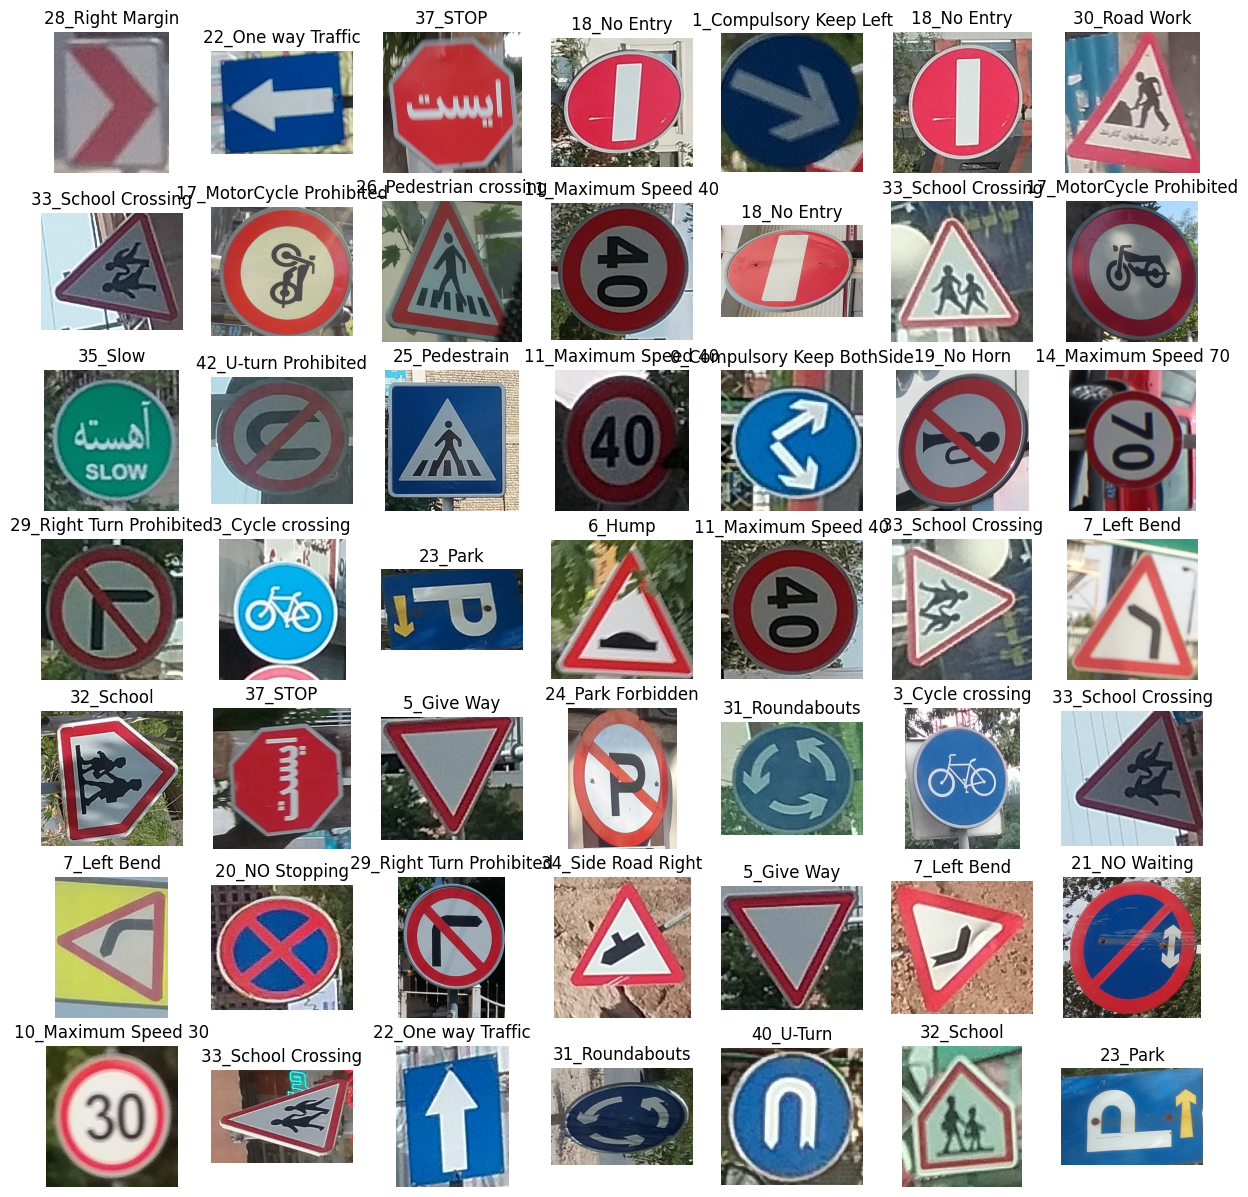

In [4]:
import random as rand

def displayImageRandom(images, labels, n = 49):
    sqrt_n = int(np.ceil(np.sqrt(n))) # calculate the grid size
    fig, axs = plt.subplots(sqrt_n, sqrt_n, figsize=(15, 15)) # create a grid of subplots

    for i in range(sqrt_n * sqrt_n):
        ax = axs[i // sqrt_n, i % sqrt_n] # find the row and column of the subplot
        if i < n: # if we have images left to display
            idx = np.random.randint(0, len(images)) # choose a random image
            ax.imshow(images[idx], cmap='gray') # display the image
            ax.set_title(f"{labels[idx]}") # set the title to the label of the image
        ax.axis('off') # turn off the axis

    plt.show()

displayImageRandom(data, labels)


### Feature Extraction Color

In [5]:
def extract_colorHSV_features(image):
    # Konversi gambar ke ruang warna HSV
    hsv_image = cv.cvtColor(image, cv.COLOR_RGB2HSV)

    # Ekstrak nilai intensitas warna (Hue, Saturation, Value)
    hue = hsv_image[:, :, 0]
    saturation = hsv_image[:, :, 1]
    value = hsv_image[:, :, 2]

    # Hitung statistik untuk setiap kanal warna
    hue_mean = np.mean(hue)
    hue_std = np.std(hue)
    saturation_mean = np.mean(saturation)
    saturation_std = np.std(saturation)
    value_mean = np.mean(value)
    value_std = np.std(value)
    
    # hitung skewness
    hue_skew = stats.skew(hue.flatten())
    saturation_skew = stats.skew(saturation.flatten())
    value_skew = stats.skew(value.flatten())
    
    # hitung kurtosis
    hue_kurtosis = stats.kurtosis(hue.flatten())
    saturation_kurtosis = stats.kurtosis(saturation.flatten())
    value_kurtosis = stats.kurtosis(value.flatten())

    return hue_mean, hue_std, saturation_mean, saturation_std, value_mean, value_std, hue_skew, saturation_skew, value_skew, hue_kurtosis, saturation_kurtosis, value_kurtosis

In [6]:
# array to store all the extracted features
hueMean = []
hueStd = []
hueSkew = []
hueKurtosis = []
saturationMean = []
saturationStd = []
saturationSkew = []
saturationKurtosis = []
valueMean = []
valueStd = []
valueSkew = []
valueKurtosis = []

for i in range(len(data)):
	hue_mean, hue_std, saturation_mean, saturation_std, value_mean, value_std, hue_skew, saturation_skew, value_skew, hue_kurtosis, saturation_kurtosis, value_kurtosis = extract_colorHSV_features(data[i])
	hueMean.append(hue_mean)
	hueStd.append(hue_std)
	hueSkew.append(hue_skew)
	hueKurtosis.append(hue_kurtosis)
	saturationMean.append(saturation_mean)
	saturationStd.append(saturation_std)
	saturationSkew.append(saturation_skew)
	saturationKurtosis.append(saturation_kurtosis)
	valueMean.append(value_mean)
	valueStd.append(value_std)
	valueSkew.append(value_skew)
	valueKurtosis.append(value_kurtosis)

In [7]:
colorHSV_features = { 
	'Filename': file_name, 'Label': labels,
	'hue_mean': hueMean, 'hue_std': hueStd, 'hue_skew': hueSkew, 'hue_kurtosis': hueKurtosis,
	'saturation_mean': saturationMean, 'saturation_std': saturationStd, 'saturation_skew': saturationSkew, 'saturation_kurtosis': saturationKurtosis,
	'value_mean': valueMean, 'value_std': valueStd, 'value_skew': valueSkew,'value_kurtosis': valueKurtosis
}
df = pd.DataFrame(colorHSV_features)
df.to_csv('ColorwithoutPreprocess.csv', index=False)

hasilEkstrak = pd.read_csv('ColorwithoutPreprocess.csv')

In [8]:
x_new = hasilEkstrak.drop(columns=['Label','Filename'])
y = hasilEkstrak['Label']
x_new

,hue_mean,hue_std,hue_skew,hue_kurtosis,saturation_mean,saturation_std,saturation_skew,saturation_kurtosis,value_mean,value_std,value_skew,value_kurtosis
0,75.746516,44.825600,-0.880285,-0.719002,62.858323,56.008001,0.117125,-1.661455,180.437677,60.667781,0.243312,-1.711740
1,75.746516,44.825600,-0.880285,-0.719002,62.858323,56.008001,0.117125,-1.661455,180.437677,60.667781,0.243312,-1.711740
2,75.746516,44.825600,-0.880285,-0.719002,62.858323,56.008001,0.117125,-1.661455,180.437677,60.667781,0.243312,-1.711740
3,59.074570,43.745454,0.297574,-1.810470,77.378505,38.570645,-0.396355,-0.977224,190.107927,29.474196,0.077330,0.178757
4,59.074570,43.745454,0.297574,-1.810470,77.378505,38.570645,-0.396355,-0.977224,190.107927,29.474196,0.077330,0.178757
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,108.749202,46.837153,-0.269855,-0.347405,66.004328,52.637635,1.001843,0.294119,99.691561,60.824073,1.316240,1.378616
3996,102.272833,54.710779,-0.382847,-0.768001,56.304471,53.087723,1.271517,0.841387,113.095782,63.199091,0.862960,0.393203
3997,123.195147,57.787347,-1.019902,-0.232776,66.670864,60.994597,0.838683,-0.731480,109.778883,40.713576,0.991149,3.969678
3998,111.867552,60.842520,-0.659927,-0.917575,59.495139,58.128615,1.059558,-0.183985,114.776937,54.628511,1.015958,1.460564


### Splitting Data

In [9]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print("x_train ada %i" % len(X_train))
print("y_train ada %i" % len(y_train))
print("x_test ada %i" % len(X_test))
print("y_test ada %i" % len(y_test))

x_train ada 2800
y_train ada 2800
x_test ada 1200
y_test ada 1200


### Normalization

In [10]:
scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')
XTrainImputed = imputer.fit_transform(X_train)
XTestImputed = imputer.transform(X_test)
XTrainNorm = scaler.fit_transform(XTrainImputed)
XTestNorm = scaler.transform(XTestImputed)

## Modeling

In [11]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(XTrainNorm, y_train)
y_pred_knn = knn_model.predict(XTestNorm)

svc_model = SVC()
svc_model.fit(XTrainNorm, y_train)
y_pred_svc = svc_model.predict(XTestNorm)

rf_model = RandomForestClassifier(n_estimators=3500)
rf_model.fit(XTrainNorm, y_train)
y_pred_rf = rf_model.predict(XTestNorm)

### Evaluation

In [12]:
def evaluasi(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return accuracy, precision, recall, f1
print("KNN")
akurasiknn, presisiknn, recalknn, f1knn = evaluasi(y_test, y_pred_knn)

print("\nRandom Forest")
akurasirf, presisirf, recalrf, f1rf = evaluasi(y_test, y_pred_rf)

print("\nSVM")
akurasisvc, presisisvc, recalsvc, f1svc = evaluasi(y_test, y_pred_svc)

KNN
Accuracy: 78.67%
Precision: 79.14%
Recall: 78.67%
F1 Score: 78.33%

Random Forest
Accuracy: 91.33%
Precision: 91.84%
Recall: 91.33%
F1 Score: 91.36%

SVM
Accuracy: 75.42%
Precision: 76.92%
Recall: 75.42%
F1 Score: 75.03%


 ┌──────────┬────────────┬────────────┬────────────┬────────────┐
 |          │ Accuracy   │ Precision  │ Recall     │ F1 Score   |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |KNN       │ 0.78666667 │ 0.79135003 │ 0.78666667 │ 0.78330192 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |SVC       │ 0.75416667 │ 0.76917853 │ 0.75416667 │ 0.75031137 |
 ├──────────┼────────────┼────────────┼────────────┼────────────┤
 |RF        │ 0.91333333 │ 0.91839539 │ 0.91333333 │ 0.91359650 |
 └──────────┴────────────┴────────────┴────────────┴────────────┘


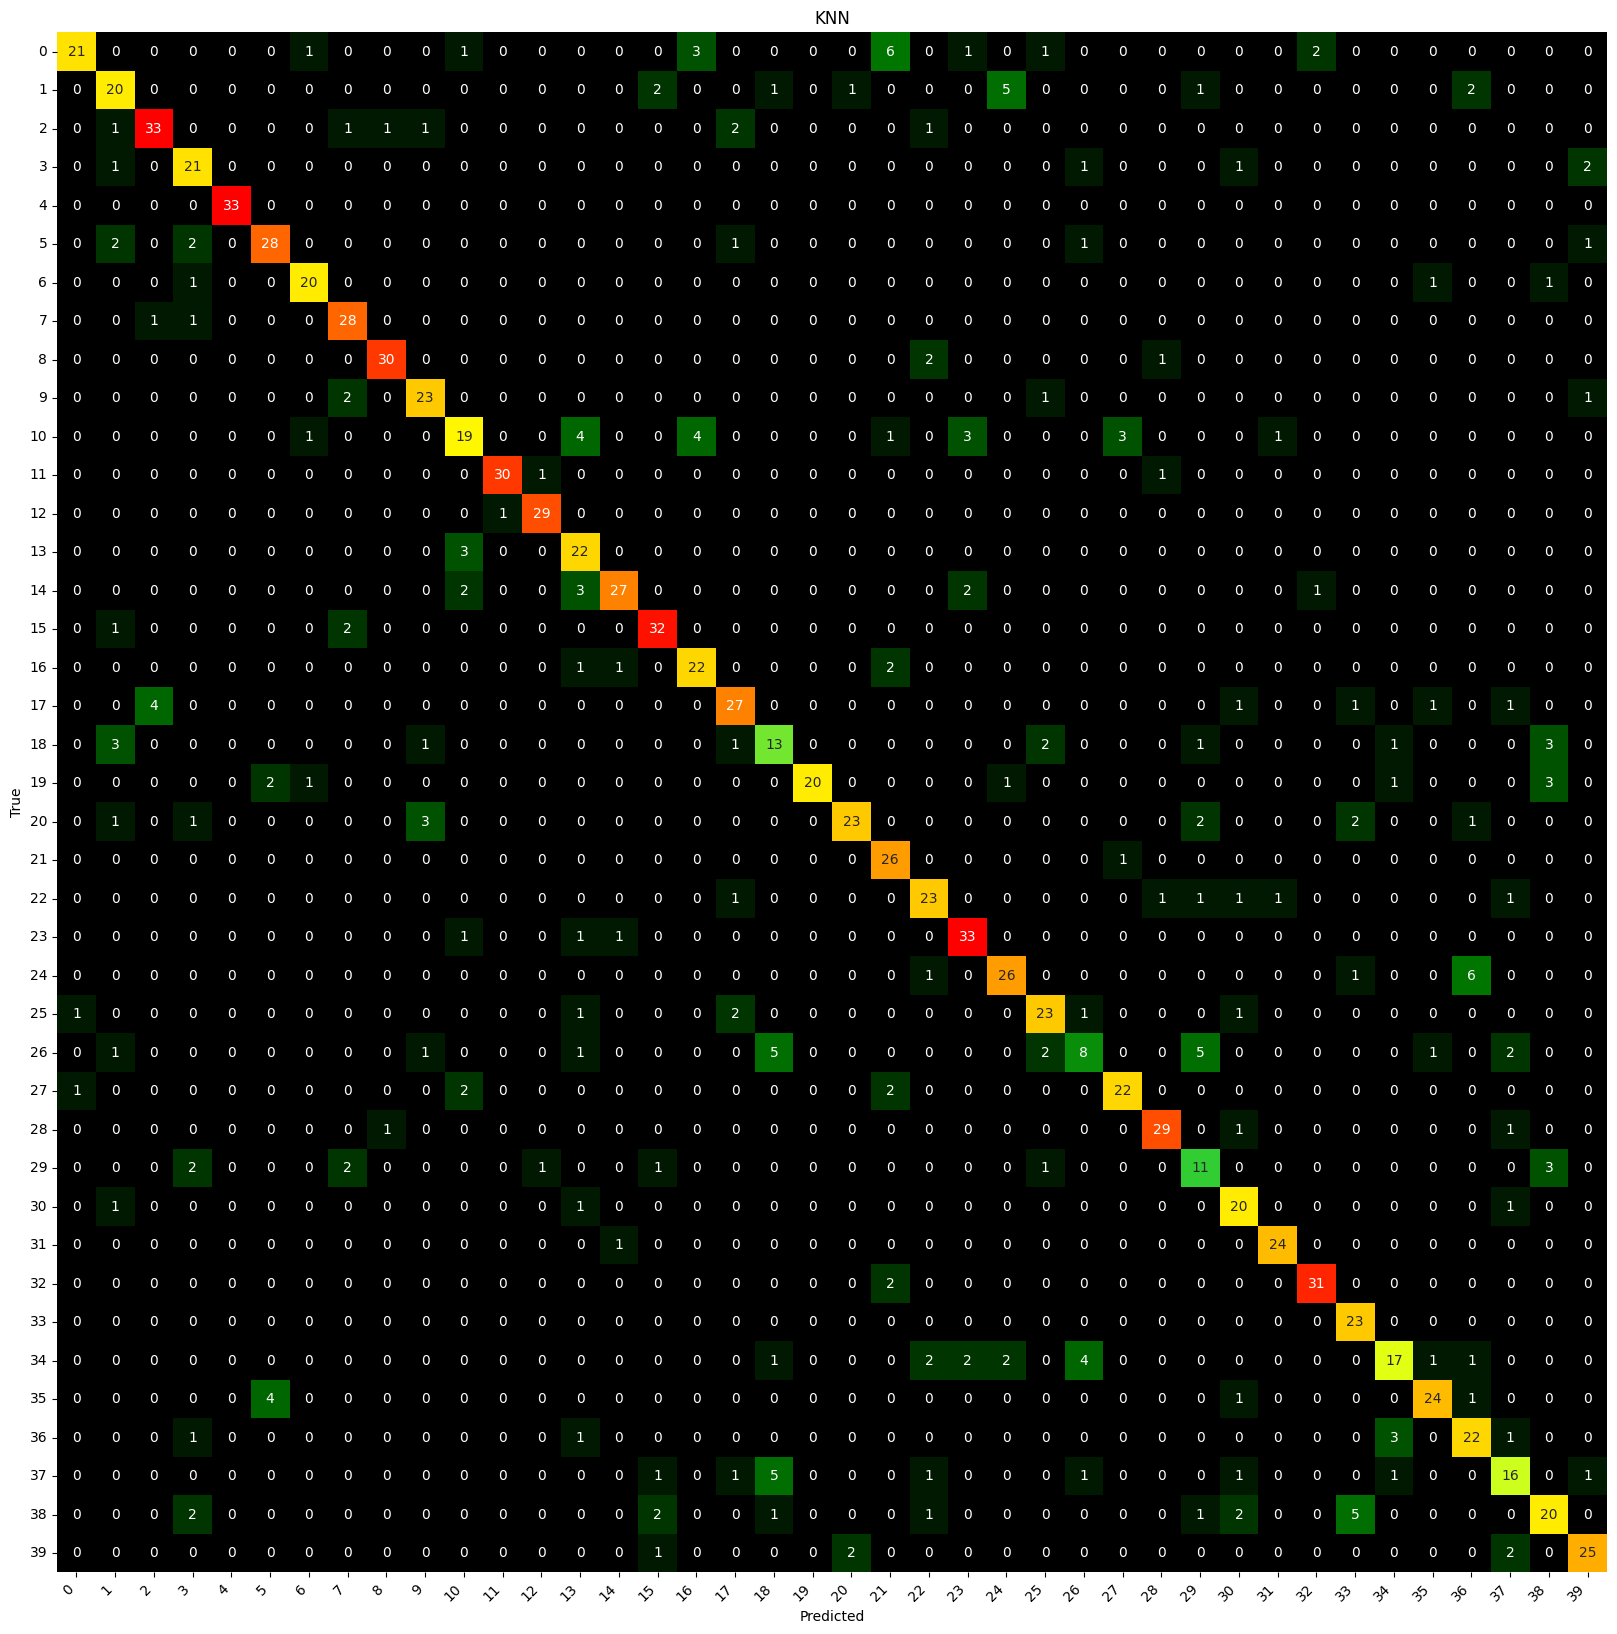

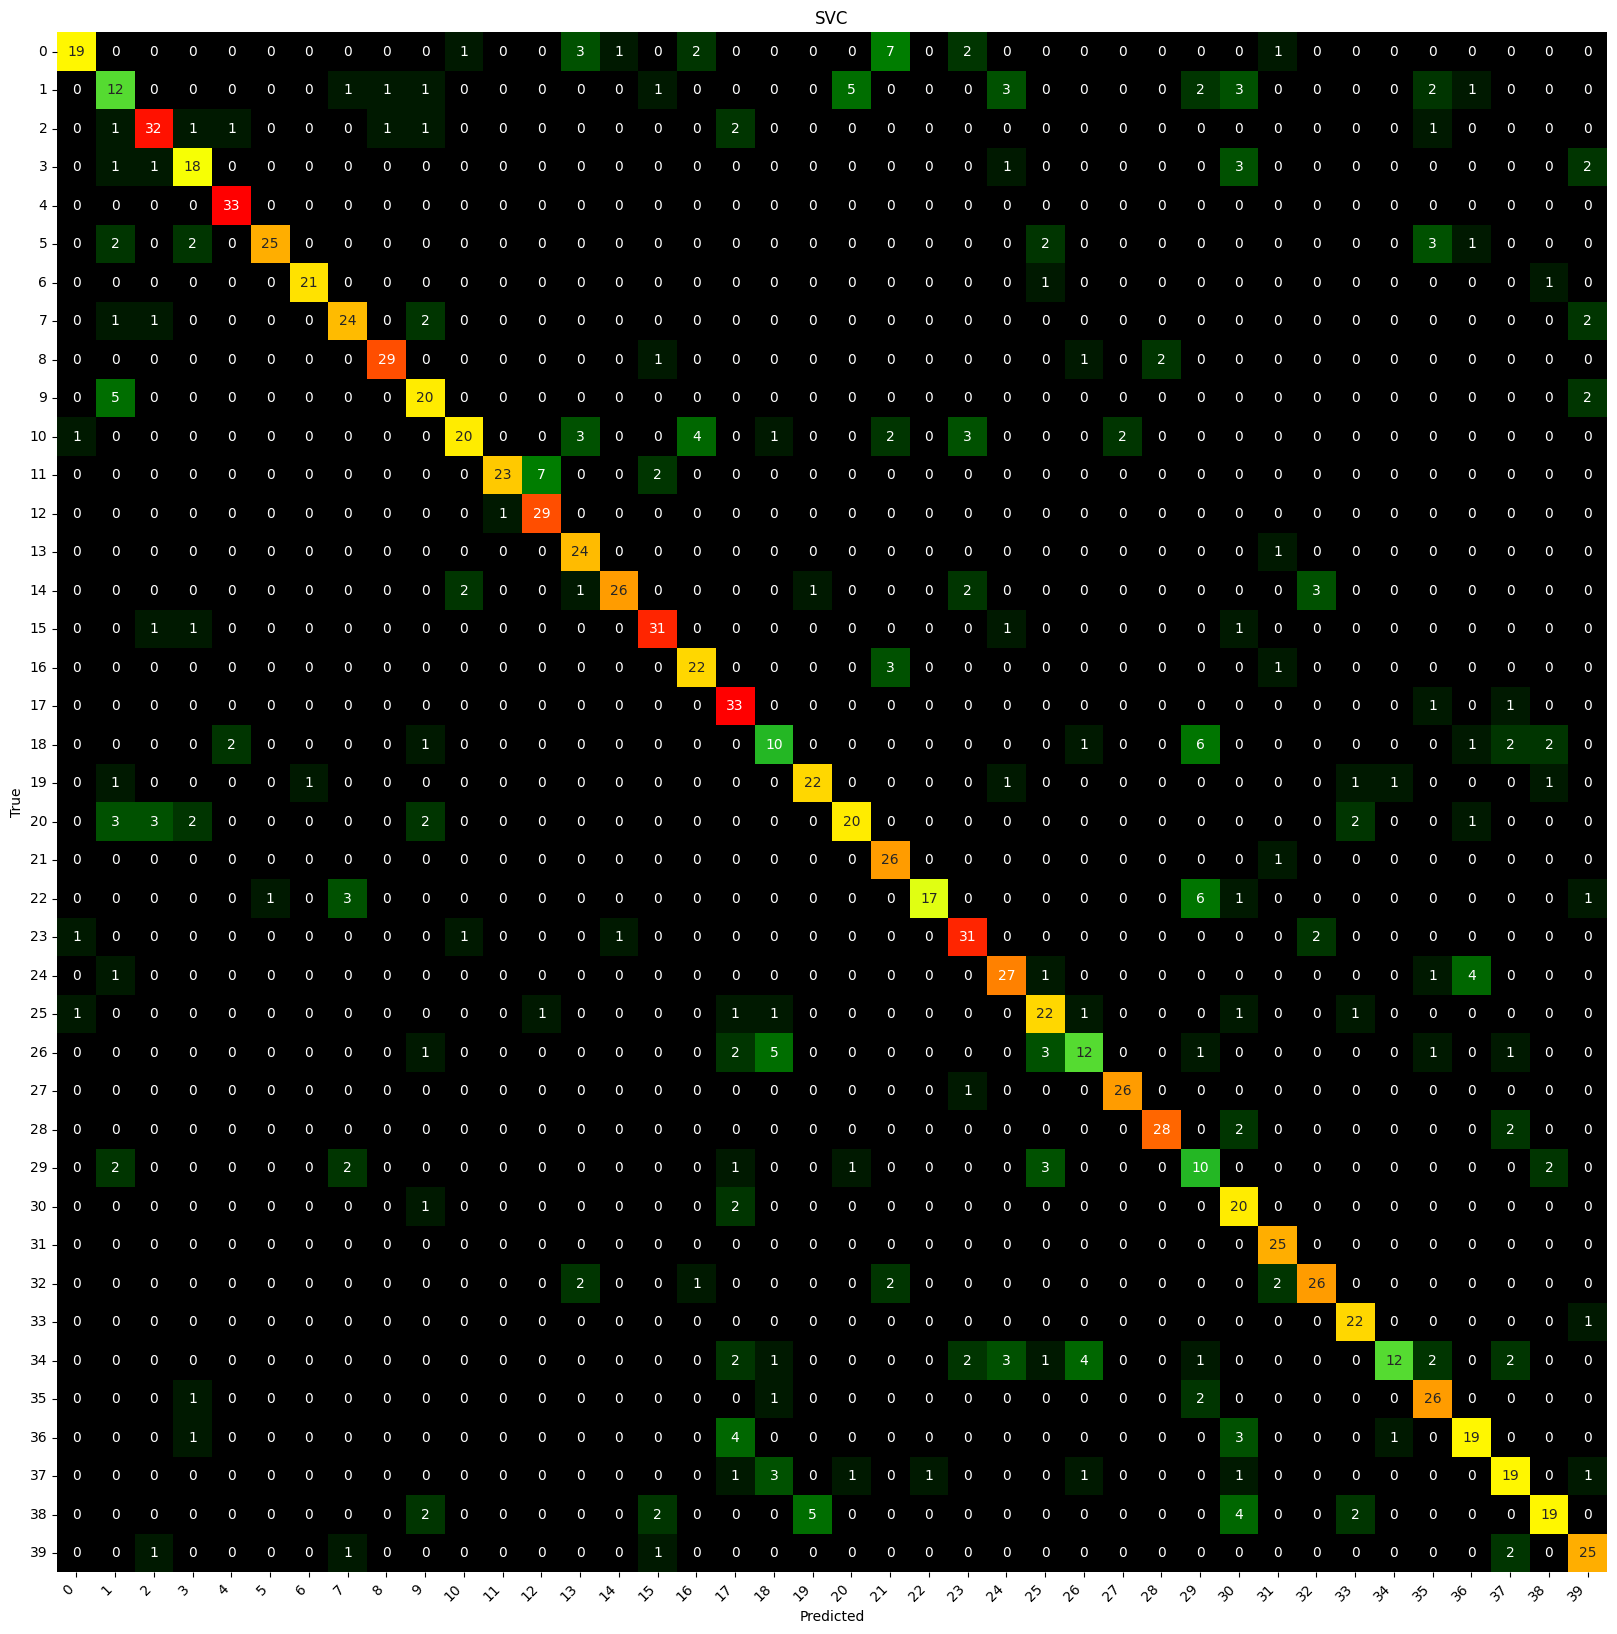

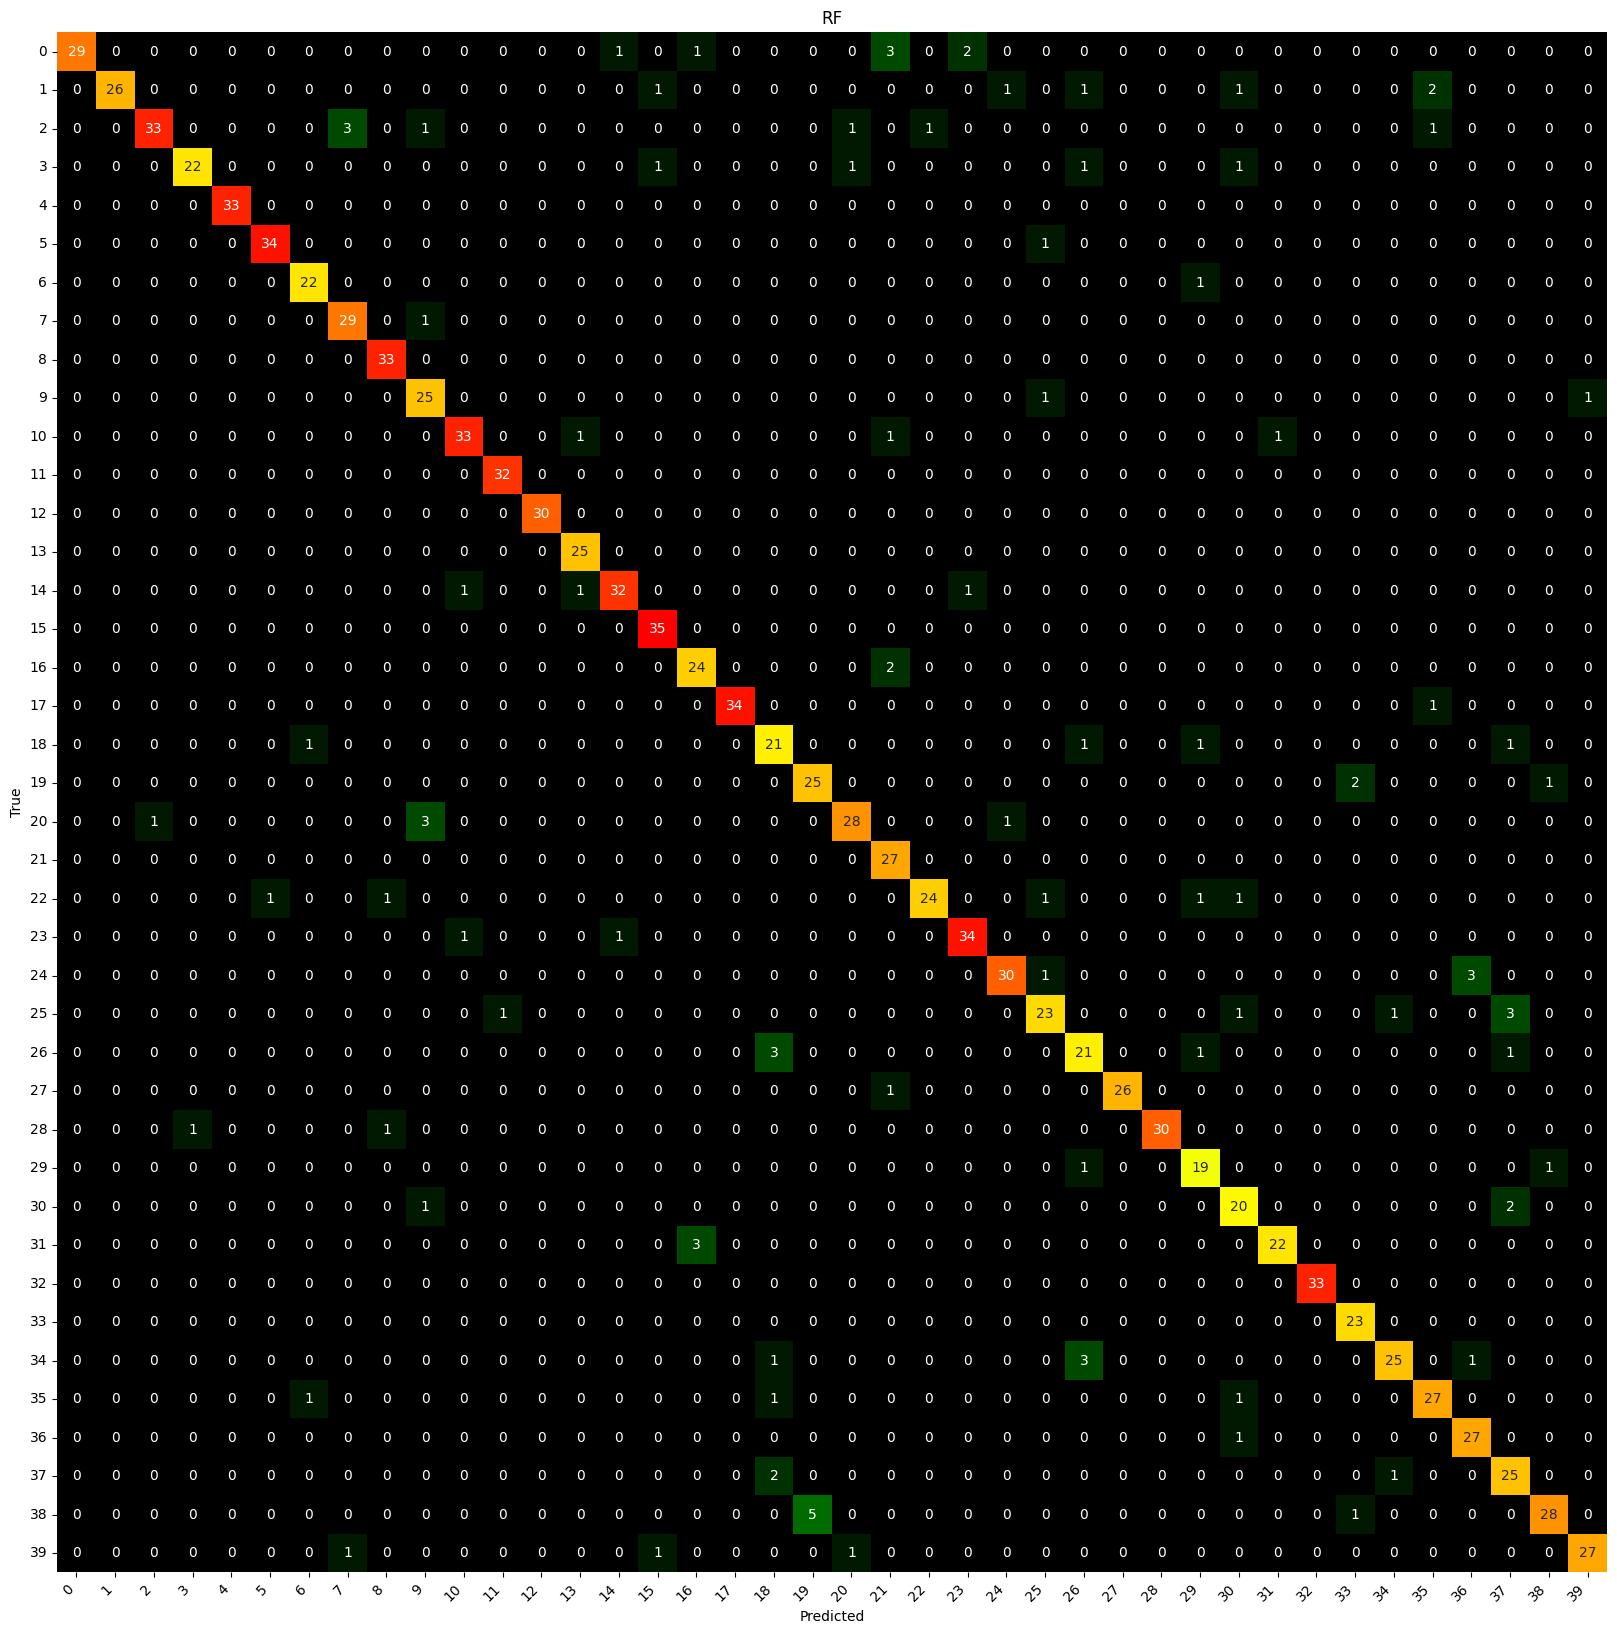

In [13]:
header = f"{' |':<10}  │ {'Accuracy':<10} │ {'Precision':<10} │ {'Recall':<10} │ {'F1 Score':<10} |"
separator = "─" * 62

top_border = f" ┌{'─' * 10}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┬{'─' * 12}┐"
mid_border = f" ├{'─' * 10}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┼{'─' * 12}┤"
bottom_border = f" └{'─' * 10}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┴{'─' * 12}┘"

row_knn = f"{' |KNN':<10}  │ {akurasiknn:<10.8f} │ {presisiknn:<10.8f} │ {recalknn:<10.8f} │ {f1knn:<10.8f} |"
row_svc = f"{' |SVC':<10}  │ {akurasisvc:<10.8f} │ {presisisvc:<10.8f} │ {recalsvc:<10.8f} │ {f1svc:<10.8f} |"
row_rf = f"{' |RF':<10}  │ {akurasirf:<10.8f} │ {presisirf:<10.8f} │ {recalrf:<10.8f} │ {f1rf:<10.8f} |"

print(top_border)
print(header)
print(mid_border)
print(row_knn)
print(mid_border)
print(row_svc)
print(mid_border)
print(row_rf)
print(bottom_border)

colorsHeat = ['#FF0000', '#FF4500', '#FFA500', '#FFD700', '#FFFF00', '#ADFF2F', '#32CD32', '#008000', '#006400', '#000000']
# reverse the colors to make it more intuitive
colorsHeat = colorsHeat[::-1]
cmap = LinearSegmentedColormap.from_list("color", colorsHeat, N=256)


plt.figure(figsize=(20, 20), facecolor='None')
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_knn), fmt='d', cbar=False)
plt.title('KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(20, 20), facecolor='None')
cm_svc = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm_svc, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_svc), fmt='d', cbar=False)
plt.title('SVC')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

plt.figure(figsize=(20, 20), facecolor='None')
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, cmap=cmap, vmin=0, vmax=np.max(cm_rf), fmt='d', cbar=False)
plt.title('RF')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
